# **Unsupervised Learning**

**This notebook has been prepared by:**
* Zizipho Tyeko
* Siyamanga Malawu
* Lejone Malokosta
* Pfano Phungo
* Mogau Mogashoa
* Dunyiswa Matshaya

How is the notebook going to work?

This notebook is a layout of a recommender system that is used to predict a movie user possible rating. The notebook will make use of the recommender system methods and techniques using sequential steps to get to the prediction of the possible expected results.


# **Movie Recommendation Challenge**

## **Recommender System**

Recommender systems are amid the most well known applications of data science today. They are used to predict the "rating" or "preference" that a user would possibly give to an item. Recommender systems uses its techniques by searching through large volume of dynamically generated information to provide users with personalized content and services.
Technically recommender system has the ability to predict whether a particular user would prefer an item or not based on the user’s profile.

# **Introduction**

The aim of this notebook is to predict how a user will rate a movie they have not yet viewed, based on their historical preference on a movie website or application e.g Netflix, Showmax or Amazon Prime.

Movie websites and applications can improve their reliability and enhance their customer experience by providing an estimated rating or preference of a movie through a recommender system used to model the predicted results.

Recommender systems are essential economically and socially in today's technology driven world. This can help movie companies in ensuring that their users can make the appropriate choices surrounding the content that they regulary engage with.

## **Problem Statement**
Can we construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

## **Aim**
Design a recommendersystem which will predict a user possible rating on a movie that they have not viewed yet based on they user history of their movie ratings.

## **Scope**
The scope of this project is to analyse and search through large volume of dynamically generated information consisting of movie ratings given by a user and information describing the movie.
These ratings will be used to train machine learning models to help with the prediction of the ratings given by a user on an unseen movie. This could also help with providing users with personalised content and services.

<img src="https://posteet.com/wp-content/uploads/2019/11/movies.png" width=90%>

# **Table of Content**

1. Import packages
2. Loading Datasets
3. Data Description
4. Explanotory Data Analysis
5. Data Filtering
6. Varibale Selection
7. Modeling
8. Model Comparison
9. Model Explanation
10. Submission
11. Application Pickled files


## 1. Importing packages

In [ ]:
# utilities
import numpy as np
import pandas as pd

#pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
plt.style.use('ggplot')
%matplotlib inline
sns.set()

from sklearn.metrics import mean_squared_error
from scipy import stats
#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

import surprise

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#wordcloud
from wordcloud import WordCloud, STOPWORDS

#datetime
import datetime
from timeit import default_timer

#others
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 2. Loading Datasets

This section loads and checks the data needed to run this notebook.
To ensure the notebook runs without any error, the relevent csv files need to be present in the notebook's directory before running the next cell.

In [2]:
train = pd.read_csv('../input/edsa-recommender-system-predict/train.csv') 
test = pd.read_csv('../input/edsa-recommender-system-predict/test.csv')
scores = pd.read_csv('../input/edsa-recommender-system-predict/genome_scores.csv')
tags = pd.read_csv('../input/edsa-recommender-system-predict/genome_tags.csv')
imdb = pd.read_csv('../input/edsa-recommender-system-predict/imdb_data.csv')  
movies = pd.read_csv('../input/edsa-recommender-system-predict/movies.csv')

# 3. Data Description

Now that we have loaded the datasets into the notebook here we display the information of the data, check if there are gaps or blanks in the dataset and check for the balance of the sentiments in the overal dataset.

### 3.1 Checking the data types of the data sets and the unique values of the rating column in the train dataset

In [3]:
print(train.info())
print('The sentiments are as follows: /n')
print(train['rating'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None
The sentiments are as follows: /n
[4.  4.5 5.  2.  3.  1.  3.5 2.5 0.5 1.5]


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


### 3.2 Checking and removing null values from the datasets that we are planning to use

In [7]:
print("No of Nan values in our dataframe : ", sum(train.isnull().any()))

No of Nan values in our dataframe :  0


In [8]:
print("No of Nan values in our dataframe : ", sum(test.isnull().any()))

No of Nan values in our dataframe :  0


In [9]:
print("No of Nan values in our dataframe : ", sum(movies.isnull().any()))

No of Nan values in our dataframe :  0


### 3.3 Checking and removing duplicate values

In [10]:
# Remove duplicate entries for userId, movieId and rating in the train dataset 
dup_bool = train.duplicated(['userId','movieId','rating'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [11]:
# Remove duplicate entries for userId, movieId in the test dataset 
dup_bool = test.duplicated(['userId','movieId'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [12]:
# Remove duplicate entries for movieId, title, genres in the movies dataset 
dup_bool = movies.duplicated(['movieId', 'title', 'genres'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


# **4. Exploratory Data Analysis**

### 4.1 Calculating the number of user's, movies and ratings

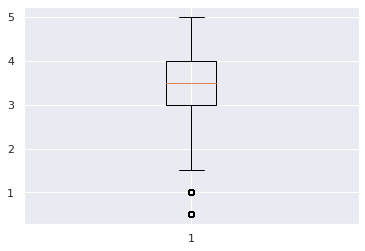

In [13]:
#box plot for ratings
box = train['rating']
plt.boxplot(box)
plt.show()

In [14]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",train.shape[0])
print("Total No of Users   :", len(np.unique(train.userId)))
print("Total No of movies  :", len(np.unique(train.movieId)))

Total data 
--------------------------------------------------

Total no of ratings : 10000038
Total No of Users   : 162541
Total No of movies  : 48213


In [15]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

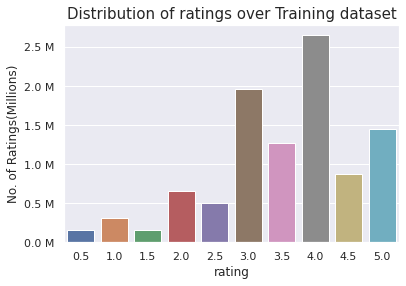

In [16]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

In the above graph we can see that we have over 2.5 million 4.0 scale number of ratings follwed by the 3.0 scale that has a little below 2 million number of ratings and in 3rd place it is the 5.0 scale that has a little below 1.5 million ratings. 

### 4.2 Analysis of ratings of a movie given by a user

In [17]:
train_df = train.copy()
movie_df = movies.copy()

In [18]:
#Split the train data into a training set and test set data for training the model. 
#The data is split into 80:20 ratio.
X_df = train_df.iloc[:int(train_df.shape[0]*0.80)]
y_df = train_df.iloc[int(train_df.shape[0]*0.80):]

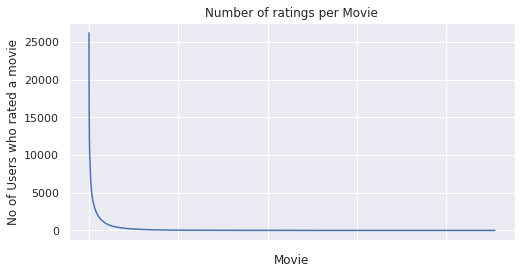

In [19]:
no_of_ratings_per_movie = X_df.groupby(by='movieId')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('Number of ratings per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

The plot is very skewed.. just like number of ratings given per user.

There are some movies which are very popular which are rated by a huge number of users, though they are very few (less than 15 %).

But most of the movies(about 85%) have ratings below 1000.

### 4.3 Converting timestamp column into date time

In [20]:
train_weekly = train.copy()
movies_weekly = movies.copy()

In [21]:
#converting timestamp column to datetime
train_weekly['timestamp'] = pd.to_datetime(train_weekly['timestamp'], unit='ms')
train_weekly.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1970-01-18 13:45:49.992
1,106343,5,4.5,1970-01-14 23:03:58.739
2,146790,5459,5.0,1970-01-13 10:56:55.539
3,106362,32296,2.0,1970-01-17 11:17:22.565
4,9041,366,3.0,1970-01-10 15:29:35.837


#### 4.3.1 Adding a day of week column in the train data set to analyse ratings on each day of the week

In [22]:
#extracting days of the week
train_weekly['day_of_week'] = train_weekly['timestamp'].dt.dayofweek
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
train_weekly['day_of_week'] = train_weekly['day_of_week'].apply(lambda x: days[x])
train_weekly.tail()

,userId,movieId,rating,timestamp,day_of_week
10000033,136395,99114,5.0,1970-01-18 14:33:55.092,Sun
10000034,140078,553,3.0,1970-01-12 14:29:40.977,Mon
10000035,154807,56782,4.0,1970-01-15 05:01:14.807,Thurs
10000036,85805,327,4.0,1970-01-18 03:05:21.530,Sun
10000037,139457,1009,4.0,1970-01-10 22:36:24.862,Sat


Text(0, 0.5, 'Days of the week')

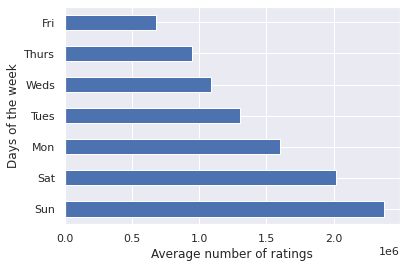

In [23]:
#plotting average number of ratings for each day
train_weekly['day_of_week'].value_counts().plot(kind='barh')
plt.xlabel('Average number of ratings')
plt.ylabel('Days of the week')

We calcated the average rating for each day of the week and we can see that we receive the most ratings on a Sunday and on a Saturday. As that would be the time that user's are more settled at home, because it would be end of week and thats the time that most user's would have time to watch movies.
We also notices that the ratings are for for one one month only which is for the month of January

### 4.4 Analysis of ratings given by a user

In [24]:
no_of_rated_movies_per_user = X_df.groupby(by='userId')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

userId
72315     10401
80974      2938
137293     2856
33844      2548
20055      2465
Name: rating, dtype: int64

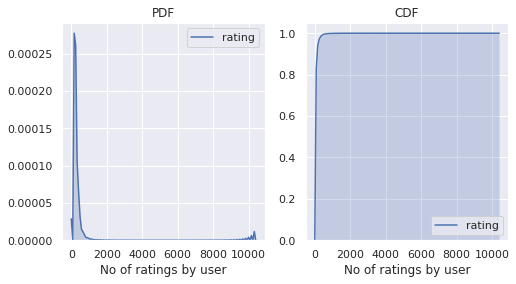

In [25]:
#plotting the PDF and CDF graphs
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

Most users seem to have low ratings. This is evident from the PDF plot above as number of ratings by user is very low after 2000 ratings. There also seems to be some more users with ratings around 10 000 and less. We now have to investigate the distribution of the ratings further.

In [26]:
no_of_rated_movies_per_user.describe()

count    162541.000000
mean         49.218536
std          86.009691
min           1.000000
25%          11.000000
50%          23.000000
75%          52.000000
max       10401.000000
Name: rating, dtype: float64

In [27]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

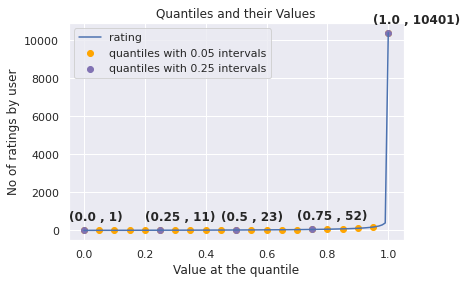

In [28]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [29]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 177)) )


 No of ratings at last 5 percentile : 8214



As per our observation earlier, number of ratings at last 5 percentile is 8214 out of 162541 ratings. The mean ratings is 49.218536 with standard deviation of 86.009691.

### 4.5 Calculating the number of movies per genre

In [30]:
movies_df = movies.copy()

In [31]:
# Split the genres into individual genres
genre_labels = set()
for s in movies_df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre appear
def count_genre(dataset, ref_col, census):
    genre_count = dict()
    for s in census: 
        genre_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                genre_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    genre_freq = []
    for k,v in genre_count.items():
        genre_freq.append([k,v])
    genre_freq.sort(key = lambda x:x[1], reverse = True)
    return genre_freq, genre_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
genre_freq, dum = count_genre(movies_df, 'genres', genre_labels)
genre_freq[:5]

[['Drama', 25606],
 ['Comedy', 16870],
 ['Thriller', 8654],
 ['Romance', 7719],
 ['Action', 7348]]

In [32]:
# Convert the frequency to dictionary
genres = dict()
trunc_freq = genre_freq[0:18]
for s in trunc_freq:
    genres[s[0]] = s[1]
    
# Convert to Dataframe
df=pd.DataFrame.from_dict(genres, orient='index').transpose()
df

,Drama,Comedy,Thriller,Romance,Action,Horror,Documentary,Crime,(no genres listed),Adventure,Sci-Fi,Children,Animation,Mystery,Fantasy,War,Western,Musical
0,25606,16870,8654,7719,7348,5989,5605,5319,5062,4145,3595,2935,2929,2925,2731,1874,1399,1054


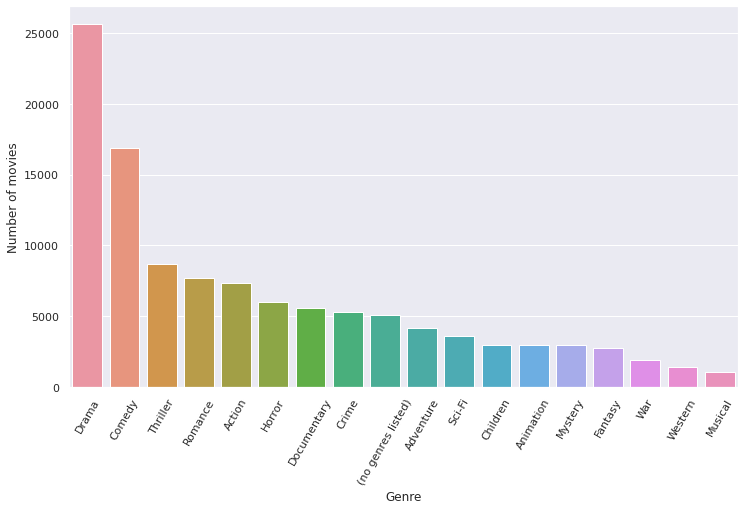

In [33]:
genres_list = list(genres.keys())

# Plot a bar plot of genres sorted in ascending order
plt.figure(figsize=(12,7))
genre_counts = df.loc[:,genres_list].sum().sort_values(ascending=False)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=60)
plt.xlabel('Genre')
plt.ylabel('Number of movies');

In the above histogram we can see that the Drama genre seems to be having the most movies tags with a little over 25000 released movies followed by the Comedy genre that has over over 15000 movies. This could possible mean that most ratings are coming from these two genres as well.

### 4.6 Calculating the number of movies released each year and number of ratings each year

Before we can run any graphs we first need to do the following:

* Split title and year into separate columns. Convert year to datetime.
* Categorize genres properly: split strings into boolean columns per genre.
* Modify the rating timestamp: from universal seconds to datetime year.
* Check for NaN values. Clean (delete rows) if % of NaN values is small.

In [34]:
train_df1 = train.copy() 
movies_df1 = movies.copy()
train_df1.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [35]:
start = default_timer()

In [36]:
st = default_timer()

    
# Organise a bit and store into feather-format
movies_df1.sort_values(by='movieId', inplace=True)
movies_df1.reset_index(inplace=True, drop=True)
train_df1.sort_values(by='movieId', inplace=True)
train_df1.reset_index(inplace=True, drop=True)

print(train_df1.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies_df1['year'] = movies_df1.title.str.extract("\((\d{4})\)", expand=True)
movies_df1.year = pd.to_datetime(movies_df1.year, format='%Y')
movies_df1.year = movies_df1.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies_df1.title = movies_df1.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies_df1.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies_df1 = movies_df1.join(movies_df1.genres.str.get_dummies().astype(bool))
movies_df1.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
train_df1.timestamp = pd.to_datetime(train_df1.timestamp, infer_datetime_format=True)
train_df1.timestamp = train_df1.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies_df1.isnull().sum()))
print ("Number of ratings Null values: ", max(train_df1.isnull().sum()))
movies_df1.dropna(inplace=True)
train_df1.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies_df1.sort_values(by='movieId', inplace=True)
train_df1.sort_values(by='movieId', inplace=True)
movies_df1.reset_index(inplace=True, drop=True)
train_df1.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
Number of movies Null values:  410
Number of ratings Null values:  0
Elapsed time(sec):  12.52


Let's plot the graph

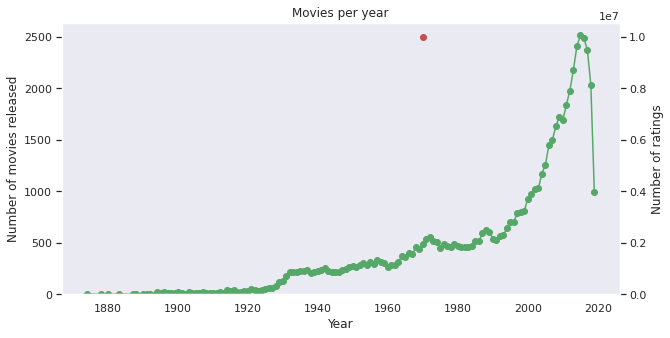

Elapsed time(sec):  0.96


In [37]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies_df1[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = train_df1[['rating', 'timestamp']].groupby('timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

Number of movies released per year increasing almost exponentially until 2010, then flattening and dropping signifincantly in 2011. This could possiblymean that expontential growth (i.e. bubbles) is seldom sustainable in the long term.
Also the ratings was only done for on year. Hence the total number of ratings per year is not showing, it is only showing for the year 1970, January.

In [38]:
#adding a year and month column to the train dataset to see when the ratings where made
from datetime import datetime
train_yr_mnth =  train.copy()


train_yr_mnth['year'] = train_yr_mnth['timestamp'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).year)
train_yr_mnth['month'] = train_yr_mnth['timestamp'].apply(lambda timestamp: datetime.fromtimestamp(timestamp).month)
train_yr_mnth.head()

#train1['year'] = pd.DatetimeIndex(train1['timestamp']).year
#train1['month'] = pd.DatetimeIndex(train1['timestamp']).month
#train1.tail()

,userId,movieId,rating,timestamp,year,month
0,5163,57669,4.0,1518349992,2018,2
1,106343,5,4.5,1206238739,2008,3
2,146790,5459,5.0,1076215539,2004,2
3,106362,32296,2.0,1423042565,2015,2
4,9041,366,3.0,833375837,1996,5


In [39]:
train_df1 = train_yr_mnth.copy() 
movies_df1 = movies.copy()

In [40]:
st = default_timer()

    
# Organise a bit and store into feather-format
movies_df1.sort_values(by='movieId', inplace=True)
movies_df1.reset_index(inplace=True, drop=True)
train_df1.sort_values(by='movieId', inplace=True)
train_df1.reset_index(inplace=True, drop=True)

print(train_df1.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies_df1['year'] = movies_df1.title.str.extract("\((\d{4})\)", expand=True)
movies_df1.year = pd.to_datetime(movies_df1.year, format='%Y')
movies_df1.year = movies_df1.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies_df1.title = movies_df1.title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies_df1.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies_df1 = movies_df1.join(movies_df1.genres.str.get_dummies().astype(bool))
movies_df1.drop('genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
#train_df1.timestamp = pd.to_datetime(train_df1.timestamp, infer_datetime_format=True)
#train_df1.timestamp = train_df1.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies_df1.isnull().sum()))
print ("Number of ratings Null values: ", max(train_df1.isnull().sum()))
movies_df1.dropna(inplace=True)
train_df1.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies_df1.sort_values(by='movieId', inplace=True)
train_df1.sort_values(by='movieId', inplace=True)
movies_df1.reset_index(inplace=True, drop=True)
train_df1.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

userId         int64
movieId        int64
rating       float64
timestamp      int64
year           int64
month          int64
dtype: object
Number of movies Null values:  410
Number of ratings Null values:  0
Elapsed time(sec):  6.85


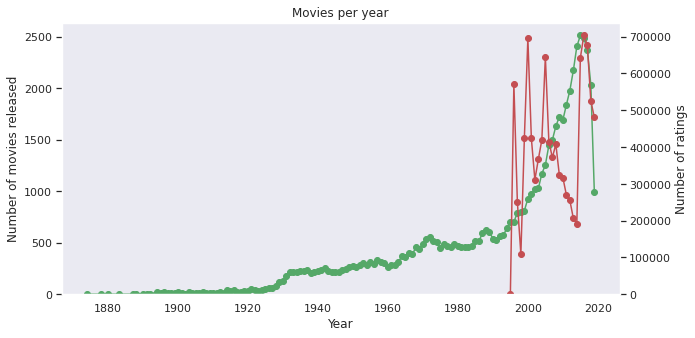

Elapsed time(sec):  0.98


In [41]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies_df1[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = train_df1[['rating', 'year']].groupby('year')
ax2 = ax1.twinx()
ax2.plot(dftmp.year.first(), dftmp.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

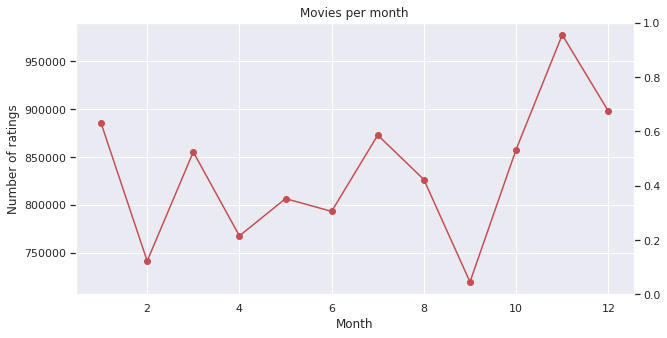

In [42]:
fig, ax1 = plt.subplots(figsize=(10,5))
dftmp1 = train_df1[['rating', 'month']].groupby('month')
ax2 = ax1.twinx()
ax1.plot(dftmp1.month.first(), dftmp1.rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Month')
#ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
ax1.set_ylabel('Number of ratings')
plt.title('Movies per month')
plt.show()

### 4.8 Lets take a look at the imdb dataset

In [43]:
imdb_df = imdb.copy()
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [44]:
imdb_df.describe()

,movieId,runtime
count,27278.000000,15189.000000
mean,59855.480570,100.312331
std,44429.314697,31.061707
min,1.000000,1.000000
25%,6931.250000,89.000000
50%,68068.000000,98.000000
75%,100293.250000,109.000000
max,131262.000000,877.000000


In [45]:
imdb_df.dtypes

movieId            int64
title_cast        object
director          object
runtime          float64
budget            object
plot_keywords     object
dtype: object

In [46]:
imdb_df['budget'].replace(regex=True, inplace=True, to_replace=r'[^0-9.\-]',value=r'') 
imdb_df['budget'] = imdb_df['budget'].astype(float)

In [47]:
imdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,30000000.0,toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,65000000.0,board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,25000000.0,boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,16000000.0,black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,30000000.0,fatherhood|doberman|dog|mansion


In [48]:
movies_df = movies.copy()

In [49]:
#extracting the year from the title column
movies_df['Year'] = movies_df['title'].str.extract(r'(?!\()\b(\d+){1}')
movies_df.head()

,movieId,title,genres,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [50]:
# create short list of unwanted columns
labels = ['timestamp']

# declare the features to be all columns, less the unwanted ones from above
features = [col for col in train.columns if col not in labels]

Trying out the new EDA

In [51]:
train_df1 = train.copy() 
movies_df1 = movies.copy()

In [52]:
start = default_timer()

In [53]:
st = default_timer()    
# Organise a bit and store into feather-format
movies_df1.sort_values(by='movieId', inplace=True)
movies_df1.reset_index(inplace=True, drop=True)
train_df1.sort_values(by='movieId', inplace=True)
train_df1.reset_index(inplace=True, drop=True)

print(train_df1.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [54]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies_df1['year'] = movies_df1.title.str.extract("\((\d{4})\)", expand=True)
movies_df1.year = pd.to_datetime(movies_df1.year, format='%Y')
movies_df1.year = movies_df1.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies_df1.title = movies_df1.title.str[:-7]

In [55]:
movies_df1.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [56]:
# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies_df1.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies_df1 = movies_df1.join(movies_df1.genres.str.get_dummies().astype(bool))
movies_df1.drop('genres', inplace=True, axis=1)

In [57]:
genres_unique.head(5)

,genre
0,Adventure
1,Animation
2,Children
3,Comedy
4,Fantasy


In [58]:
# Modify rating timestamp format (from seconds to datetime year)
train_df1.timestamp = pd.to_datetime(train_df1.timestamp, infer_datetime_format=True)
train_df1.timestamp = train_df1.timestamp.dt.year

In [59]:
train_df1.head()

,userId,movieId,rating,timestamp
0,120877,1,3.0,1970
1,113986,1,4.0,1970
2,5152,1,4.0,1970
3,93168,1,4.0,1970
4,108001,1,3.0,1970


In [60]:
# Check and clean NaN values
print ("Number of movies Null values: ", max(movies_df1.isnull().sum()))
print ("Number of ratings Null values: ", max(train_df1.isnull().sum()))
movies_df1.dropna(inplace=True)
train_df1.dropna(inplace=True)

Number of movies Null values:  410
Number of ratings Null values:  0


In [61]:
# Organise a bit, then save into feather-formatand clear from memory
movies_df1.sort_values(by='movieId', inplace=True)
train_df1.sort_values(by='movieId', inplace=True)
movies_df1.reset_index(inplace=True, drop=True)
train_df1.reset_index(inplace=True, drop=True)

In [62]:
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

Elapsed time(sec):  20.14


Lets take a look at a graph of the above data:

PLOT1: Number of movies and ratings per year. 

INSIGHT on the graph below: 

Number of movies released per year increasing almost exponentially until 2010, then flattening and dropping signifincantly in 2011. Does this confirm expontential growth (i.e. bubbles) is seldom sustainable in the long term? No ratings before 1995, likely to do with the availability of Internet to general public.

PLOT 2: Increasing number of movies, in total and per genre.
INSIGHT 2: On average, movies are categorized into 2 genres (i.e. number of movies-genres 54k doubles the number of movies 27k). Comedy 8.3k and Drama 13.3k are the top genres used.

<Figure size 720x360 with 0 Axes>

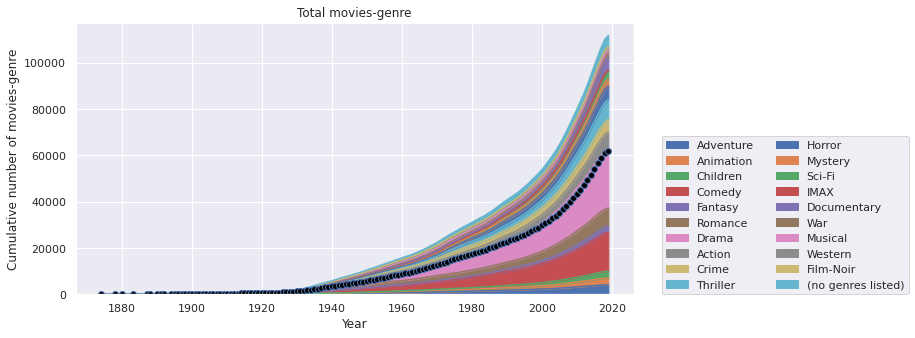

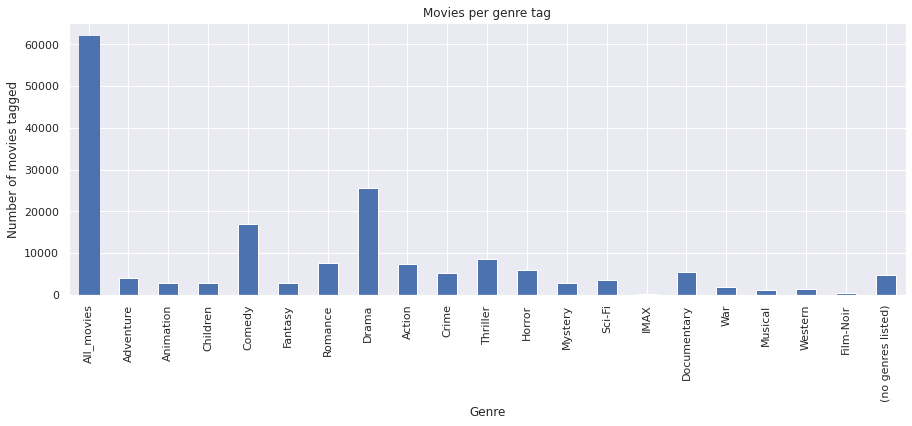

Elapsed time(sec):  1.04


In [63]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies_df1[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies_df1[movies_df1[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

Plot 3

In [64]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='ms')
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1970-01-18 13:45:49.992
1,106343,5,4.5,1970-01-14 23:03:58.739
2,146790,5459,5.0,1970-01-13 10:56:55.539
3,106362,32296,2.0,1970-01-17 11:17:22.565
4,9041,366,3.0,1970-01-10 15:29:35.837


In [65]:
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
train_df['day_of_week'] = train_df['day_of_week'].apply(lambda x: days[x])
train_df.tail()

,userId,movieId,rating,timestamp,day_of_week
10000033,136395,99114,5.0,1970-01-18 14:33:55.092,Sun
10000034,140078,553,3.0,1970-01-12 14:29:40.977,Mon
10000035,154807,56782,4.0,1970-01-15 05:01:14.807,Thurs
10000036,85805,327,4.0,1970-01-18 03:05:21.530,Sun
10000037,139457,1009,4.0,1970-01-10 22:36:24.862,Sat


With the above graph, We seem to be receiving the most ratings on a Sunday and a Saterday

In [66]:
train_df['month'] = pd.DatetimeIndex(train_df['timestamp']).month
train_df.tail()

,userId,movieId,rating,timestamp,day_of_week,month
10000033,136395,99114,5.0,1970-01-18 14:33:55.092,Sun,1
10000034,140078,553,3.0,1970-01-12 14:29:40.977,Mon,1
10000035,154807,56782,4.0,1970-01-15 05:01:14.807,Thurs,1
10000036,85805,327,4.0,1970-01-18 03:05:21.530,Sun,1
10000037,139457,1009,4.0,1970-01-10 22:36:24.862,Sat,1


All the ratings are made in January(first month) of each year.

In [67]:
movie_data = pd.merge(train, movies, on='movieId')

In [68]:
movie_data.head(2)

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [69]:
#sort mean movie rating by title in ascending order
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Final Recourse (2013)        5.0
Lady and the Tramp (2019)    5.0
Virasat (1997)               5.0
Committed (2014)             5.0
Sole Proprietor (2016)       5.0
Name: rating, dtype: float64

In [70]:
#group movies by the number of ratings in ascending order
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Shawshank Redemption, The (1994)    32831
Forrest Gump (1994)                 32383
Pulp Fiction (1994)                 31697
Silence of the Lambs, The (1991)    29444
Matrix, The (1999)                  29014
Name: rating, dtype: int64

In [71]:
#mean count of ratings
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


You can see movie title, along with the average rating and number of ratings for the movie.

A histogram for the number of ratings represented by the "rating_counts" column in the above dataframe

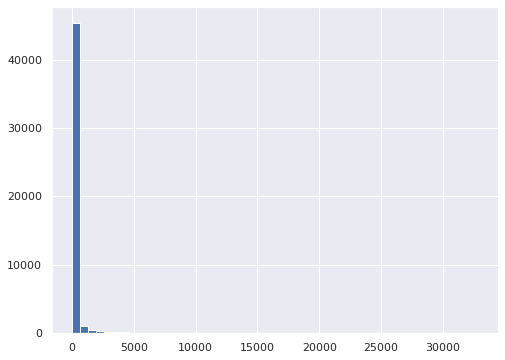

In [72]:
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

From the output, you can see that most of the movies have received less than 50 ratings. While the number of movies having more than 5000 ratings is very low.

A histogram for average ratings

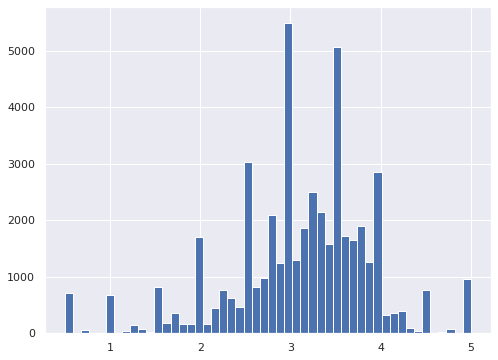

In [73]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating'].hist(bins=50)

You can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5. Furthermore, it is evident that the data has a weak normal distribution with the mean of around 3.5. There are a few outliers in the data.

Average ratings against the number of ratings:

<Figure size 576x432 with 0 Axes>

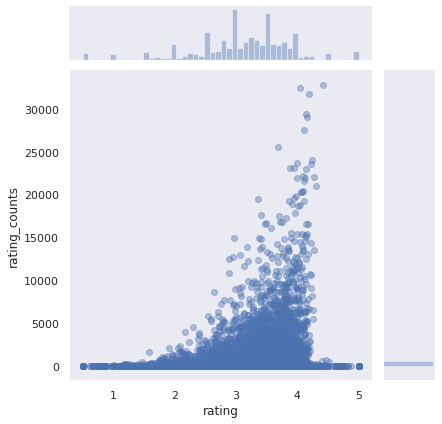

In [74]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

**Runtime of movies**

In [75]:
runtime = pd.merge(imdb, movies, on='movieId')
runtime.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords,title,genres
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995),Adventure|Children|Fantasy


In [76]:
#top 5 movies with longest running time
runtime['runtime'] = runtime['runtime'].astype(float)
b = runtime.drop(['movieId','title_cast', 'director', 'budget', 'plot_keywords', 'genres'], axis=1)
b.head()
b.nlargest(5,['runtime'])

,runtime,title
23527,877.0,Taken (2002)
17784,750.0,Law of the Lawless (Brigada) (2002)
18402,644.0,Sam Peckinpah: Man of Iron (1993)
19449,629.0,Death on the Staircase (Soupçons) (2004)
19590,600.0,New York: A Documentary Film (1999)


The longest movie is Taken (2002)

**WORDCLOUDS**

In [77]:
#wordcloud for plot keywords
imdb['plot_keywords'] = imdb['plot_keywords'].astype('str')

#wordcloud for tags
tags['tag'] = tags['tag'].astype('str')

In [78]:
plot = ' '.join(imdb['plot_keywords'])

tag = ' '.join(tags['tag'])

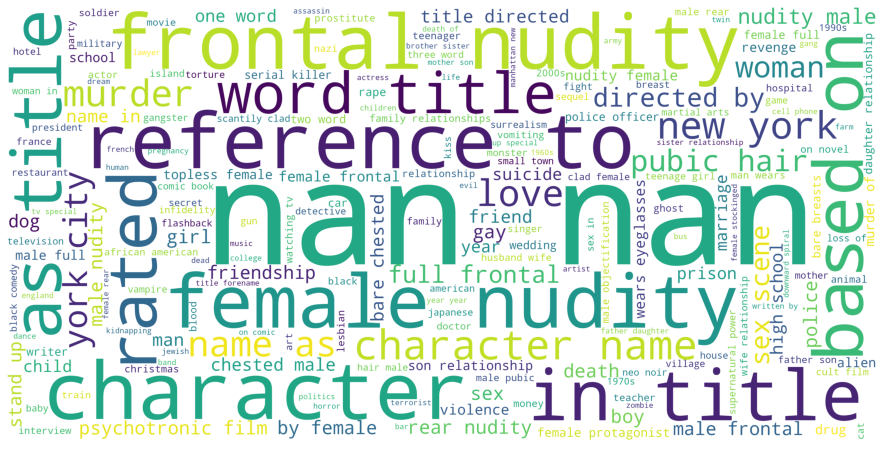

In [79]:
#wordcloud for plot keywords
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(plot)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

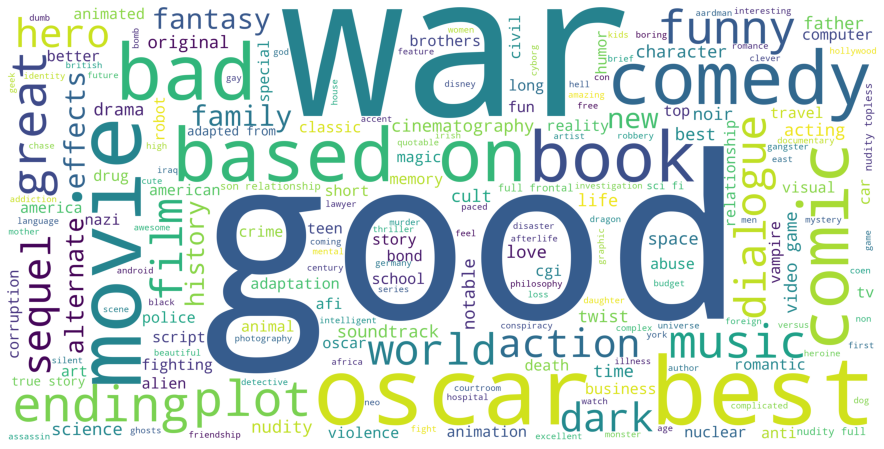

In [80]:
#wordcloud for plot keywords
overview_wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(tag)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud2)
plt.axis('off')
plt.show()

**Directors with most ratings**

In [81]:
ratings_mean = pd.DataFrame(imdb.groupby('director')['movieId'].count())
ratings_mean.tail(2)

,movieId
director,
Özhan Eren,1
Øystein Karlsen,1


In [82]:
#directors whose movies are the most rated
b = pd.merge(train, imdb, on='movieId')
mean_count = pd.DataFrame(b.groupby('director')['rating'].mean())
mean_count['rating_counts'] = pd.DataFrame(b.groupby('director')['rating'].count())
mean_count.nlargest(5,['rating_counts'])

,rating,rating_counts
director,,
Quentin Tarantino,3.936571,109919
Michael Crichton,3.273370,65157
J.R.R. Tolkien,4.080118,62963
Lilly Wachowski,3.808348,60988
Stephen King,4.049956,59903


The director with most ratings is Quentin Tarantino with an average rating of 3.9

## Fitting model

In [ ]:
train = train[0:10000]
test = test[0:10000]

In [ ]:
#Independent feature of the train dataframe
X = train.drop(['rating'], axis=1)
#Dependent feature of the train dataframe
y=train['rating']
#Independent feature of test dataframe
x_unseen=test['movieId'] #test independent feature

In [ ]:
#Splitting the train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
vectoriser = TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))

In [ ]:
#fitting the vectoriser
vectoriser.fit(X, y)

In [ ]:
#transformation of the datasets
X_train = vectoriser.transform(X)
X_test  = vectoriser.transform(X)
#x_unseen =  vectoriser.transform(x_unseen)

In [ ]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15,20,30,40],
 "min_child_weight" : [ 1, 3, 5, 7 ,9,10,11,12],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4,1,2],
 "colsample_bytree" : [ 0.2,0.3, 0.4, 0.5 , 0.7,0.8 ]
 
    
}

In [ ]:
## Hyperparameter optimization using RandomizedSearchCV
boost = xgb.XGBRegressor()

In [ ]:
random_search=RandomizedSearchCV(boost,param_distributions=params,n_iter=2,n_jobs=1,cv=2,verbose=True)

In [ ]:
random_search.fit(X,y)

In [ ]:
random_search.best_estimator_

In [ ]:
random_search.best_params_

In [ ]:
# initialize Our first XGBoost model...
boost = xgb.XGBRegressor()
boost.fit(X,y)


In [ ]:
# Getting predicions from the X_test
pred0 = boost.predict(X_test)
#checking score
mean_squared_error(y_test, pred0, squared=False)

## App Recommenders

**Content based filtering**

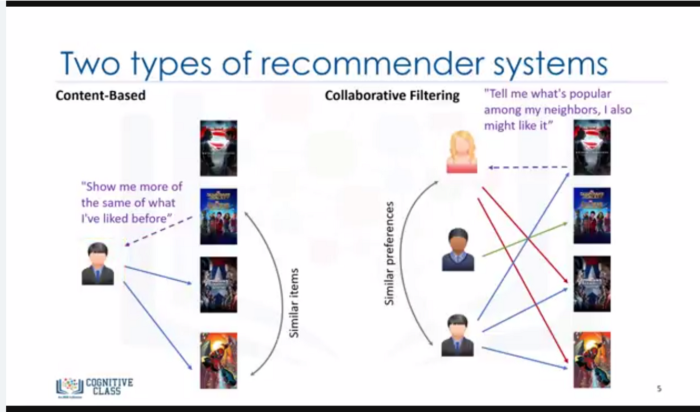
source: https://medium.com/towards-artificial-intelligence/building-a-recommender-system-with-pandas-1ca0bb03fdce

A Content-based recommender system works by recommending items (in this case items are movies) to users, based on their profile. The user’s profile is build around the their historical ratings on movies. The user's preferences are stored in a vector. All the information related to movies is stored in another vector called the item vector. Item vector contains the details of each movie, like genre, cast, director, etc.

The content-based filtering algorithm finds the cosine of the angle between the profile vector and item vector, i.e. cosine similarity. Suppose A is the profile vector and B is the item vector, then the similarity between them can be calculated as:

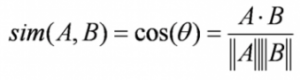
source: https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/

**Implementation**

Join the movies DataFrame with columns from imbd data.

In [84]:
movie_frames = [movies['movieId'], movies['title'], movies['genres'], imdb['title_cast'], imdb['director'], 
          imdb['runtime'], imdb['budget'], imdb['plot_keywords']]
joined_movies = pd.concat(movie_frames, axis = 1)

Combine the text features into a single text.

In [85]:
joined_movies['comb_text'] = (pd.Series(joined_movies[['title', 'genres', 'title_cast', 'director', 'budget', 'plot_keywords']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

# Convienient indexes to between map book titles and indexes of 
# the books dataframe
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])
joined_movies.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,comb_text
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,Toy Story (1995) Adventure|Animation|Children|...
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game,Jumanji (1995) Adventure|Children|Fantasy Robi...
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry,Grumpier Old Men (1995) Comedy|Romance Walter ...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...,Waiting to Exhale (1995) Comedy|Drama|Romance ...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Father of the Bride Part II (1995) Comedy Stev...


Explore the result.

In [86]:
joined_movies['comb_text'][0]

'Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wallace Shawn|John Ratzenberger|Annie Potts|John Morris|Erik von Detten|Laurie Metcalf|R. Lee Ermey|Sarah Freeman|Penn Jillette|Jack Angel|Spencer Aste John Lasseter $30,000,000 toy|rivalry|cowboy|cgi animation'

Clean the combined text data.

In [87]:
# Function to remove/replace unwanted text such as characters,URLs etc

def clean(text):
    text=text.replace("|", " ")
    text=text.replace("(",' ')
    text=text.replace(")",' ')
    text=text.lower()  # Lowercase tweet
    
    return text

In [88]:
joined_movies['comb_text']=joined_movies['comb_text'].apply(clean)
joined_movies['comb_text'][0]

'toy story  1995  adventure animation children comedy fantasy tom hanks tim allen don rickles jim varney wallace shawn john ratzenberger annie potts john morris erik von detten laurie metcalf r. lee ermey sarah freeman penn jillette jack angel spencer aste john lasseter $30,000,000 toy rivalry cowboy cgi animation'

In [ ]:
# Instantiating and generating the count matrix
#count_vec = CountVectorizer()
#count_matrix = count_vec.fit_transform(joined_movies['comb_text'])
#indices = pd.Series(data['title'])
#cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
#print(cosine_sim.shape)

Merge the train data to get title for use in the above function.

train_merge = pd.merge(train, joined_movies, how='left', on='movieId')
train_merge.head()

# drop unwanted columns
train_merge.drop(['runtime', 'budget', 'plot_keywords'], axis = 1, inplace = True)
train_merge.info()

Check to see if the function works

title = "High Noon (1952)"
actual_rating = df_merge[(train_merge['userId'] == 24006) & (df_merge['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(book_title=title, user=24006, rating_data=df_merge)

print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

## Kaggle Prediction

#### Model-Based Collaborative Filtering

Model-based Collaborative Filtering is based on matrix factorization (MF) which is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based Collaborative Filtering:

- The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
- When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.

#### Support Vector Decomposition (SVD)

A well-known matrix factorization method is Singular value decomposition (SVD). SVD is an algorithm that decomposes a matrix  𝐴  into the best lower rank (i.e. smaller/simpler) approximation of the original matrix  𝐴 . Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

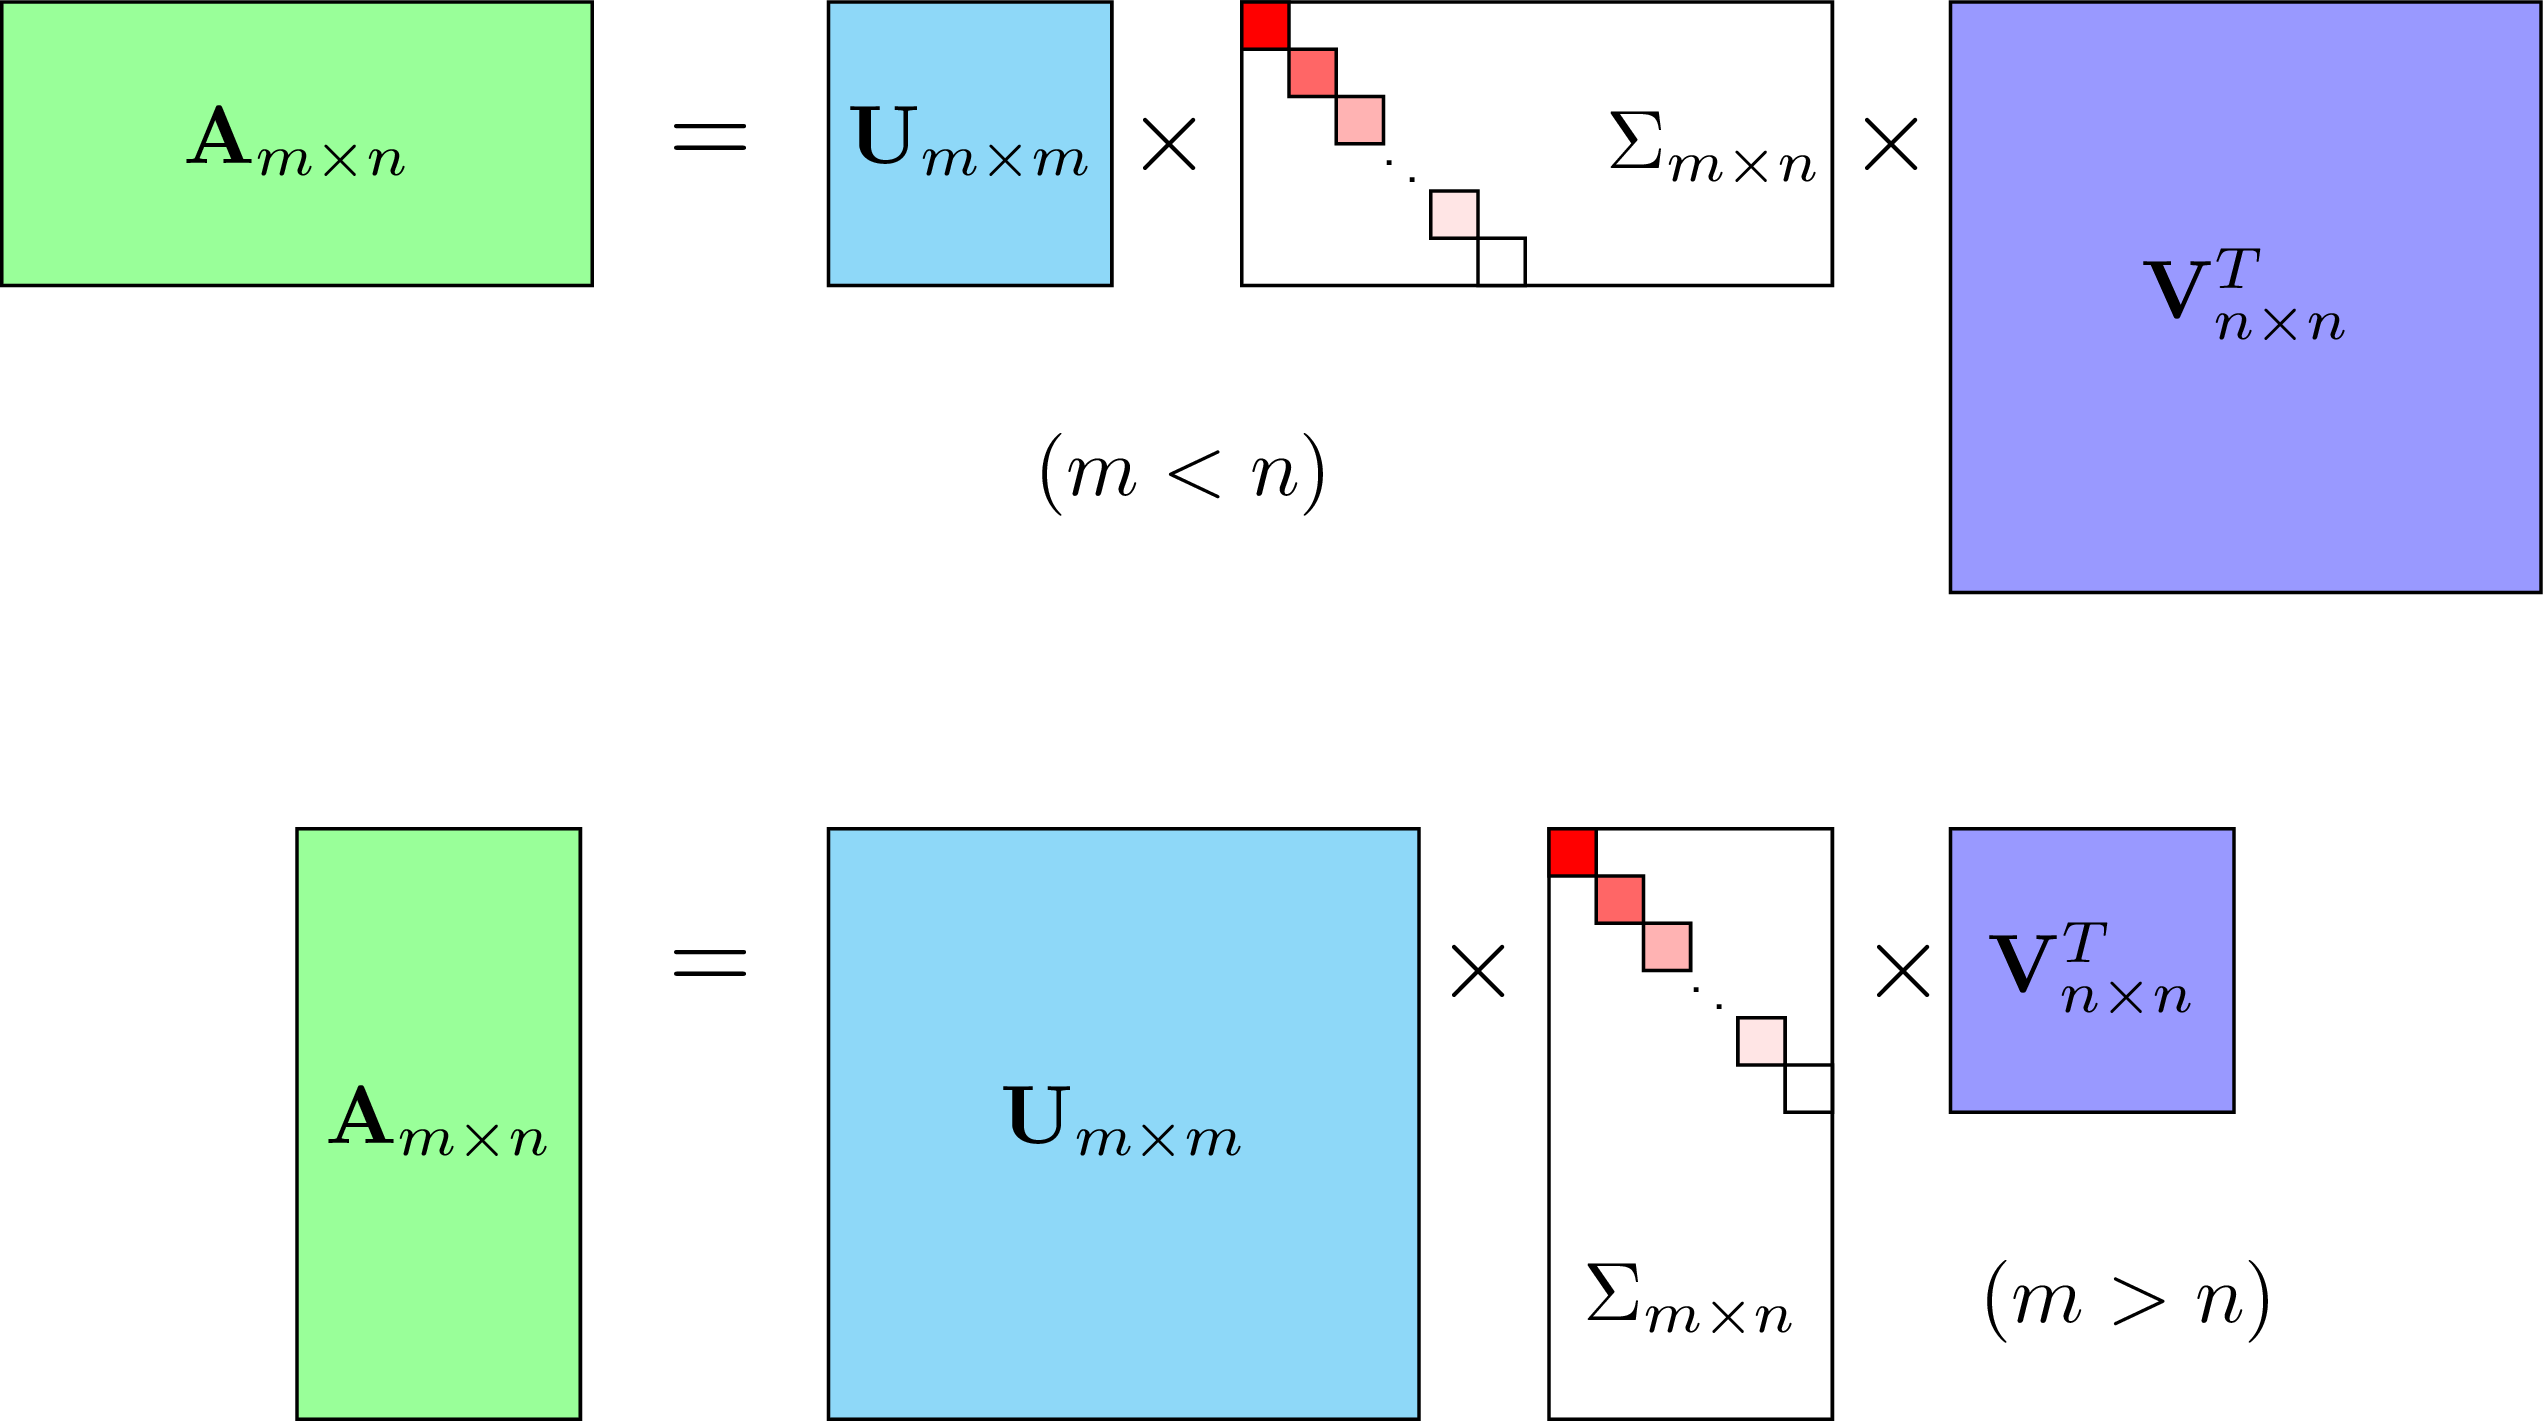
source: https://github.com/khanhnamle1994/movielens/blob/master/SVD_Model.ipynb

#### Model Evaluation

Since the data is very big (10 million rows), the train data will be sampled in batches to see how much RMSE score it produces. The data will be trained on three samples of 10%, 50% and 80%.

In [89]:
train_sample_5 = train.sample(frac =.5)

In [90]:
# Use the SVD algorithm.
algo_svd = SVD()

# Load Reader library
reader = Reader(rating_scale = (0.5, 5.0))

data_5 = Dataset.load_from_df(train_sample_5[['userId', 'movieId', 'rating']], reader)

Cross Validation

In [91]:
# Run 3-fold cross-validation for fourth sample and print results for SVD.
surprise.model_selection.cross_validate(algo_svd, data_5, measures=['RMSE'], cv=3, verbose=True, n_jobs=-1)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8827  0.8856  0.8855  0.8846  0.0014  
Fit time          450.87  443.55  422.40  438.94  12.07   
Test time         33.05   27.29   26.88   29.07   2.82    


{'test_rmse': array([0.88265423, 0.8855723 , 0.88550607]),
 'fit_time': (450.8690872192383, 443.55305433273315, 422.4049768447876),
 'test_time': (33.05228638648987, 27.28788995742798, 26.87980341911316)}

Compare Perfomance

In [92]:
# Calculate RMSE and Test Times

rmse_list = [0.9210, 0.8851, 0.8598]
fit_list = [88.71, 451.35, 721.30]
test_list = [6.36, 34.83, 57.10]

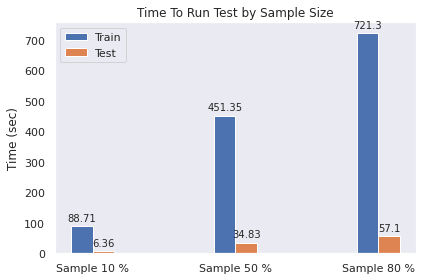

In [94]:
# plot of Run times
labels = ['Sample 10 %', 'Sample 50 %', 'Sample 80 %']

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fit_list, width, label='Train')
rects2 = ax.bar(x + width/2, test_list, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec)')
ax.set_title('Time To Run Test by Sample Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

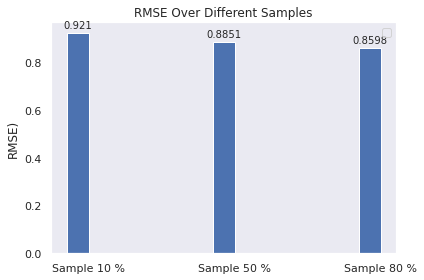

In [100]:
# plot of RMSE values

# plot of Run times
labels = ['Sample 10 %', 'Sample 50 %', 'Sample 80 %']

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects3 = ax.bar(x - width/2, rmse_list, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE)')
ax.set_title('RMSE Over Different Samples')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects3)

fig.tight_layout()

plt.show()

From the plots above, the following observations can be made:

- The time to train the model increases with the amount of data used to train it.
- The RMSE score decreases with more samples of the train dataset used.

The model will be fit using the best performing sample (all the data), and generate predictions for this model

In [ ]:
trainset = data_5.build_full_trainset()
algo_svd.fit(trainset)

In [ ]:
# Calculate the predictions
pre = []

for _, row in test.iterrows():
    x_unseen = algo_svd.predict(uid=row['userId'],iid=row['movieId'])
    pred = x_unseen[3]
    pre.append(pred)

Format the test data for submission

In [ ]:
test['Id'] = test['userId'].map(str)+ "_" +test['movieId'].map(str)
test.head()

In [ ]:
#Sellecting the index of the test dataframe
final_test= test["Id"]

#Creating the submission Dataframe
Final_Table = {'Id': final_test, 'rating':np.round(pre, 1)}
submission = pd.DataFrame(data=Final_Table)
submission = submission[['Id', 'rating']]

submission.to_csv("Submission.csv",index  = False) #wrting csv file